# AWD LSTM Q&A classification and prediction

Using the encoder from our finetuned language model in a text classification model to be trained on the competition data.

## Re-ordering predictions
As of writing the fastai `SortedDL` dataloader sorts predictions according to item size, however for kaggle we need the predictions output in the same order as the submissions file, which is generally the same order as the input test file. 

So there was 1 more step to do after making out preds before I could use them. I had to get the original indexes from the dataloader and then re-sort the preds:

``
pred_idxs = tst_cls_dls.get_idxs()
sorted_preds = [x for _,x in sorted(zip(pred_idxs, list(torch.unbind(preds[0]))))]
``


## Custom Transform
One thing I had to do to get this working was to create a custom transform in order to input and display the 30 float targets for this competition for use in the `y_tfms`, like so:

`y_tfms = [GetMultiColFloatLabels(label_cols)]`

Full Tranfrom code:

```
class TensorMultiColLabels(TensorBase):   pass

class GetMultiColFloatLabels(Transform):
    'Transform to grab multiple float labels form multiple columns from a df'
    order=1
    def __init__(self, label_cols:list=None, c:int=None):
        if not isinstance(label_cols, list): TypeError(f'label_cols must be a list')
        self.label_cols = label_cols
        if c is None: 
            self.c = len(label_cols) 
        else: self.c = c
    def encodes(self, o): return TensorMultiColLabels(tensor(list(o[self.label_cols])).float())
    # Return dict which gets parsed in the custom show_batch function
    def decodes(self, o): return {label_cols[i]:o[i] for i in range(o.size()[0])}
    
@typedispatch
def show_batch(x: TensorText, y:TensorMultiColLabels, samples, ctxs=None, max_n=10, trunc_at=150, **kwargs):
    samples = L((s[0].truncate(trunc_at),*s[1:]) for s in samples)
    fin_ls = []
    for i,s in enumerate(samples): fin_ls.append([s[0]] + list(s[1].values()))
    cols = ['doc'] + list(s[1].keys())
    display_df(pd.DataFrame(fin_ls, columns = cols))
    return fin_ls
```

In [1]:
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *
import gc
from datetime import date

from tqdm import tqdm

# Load data

In [2]:
import sys  
sys.path.insert(0, '/home/morgan/ml')
quest_trn = pd.read_csv('/home/morgan/ml/data/google-quest-challenge/train.csv')
quest_tst = pd.read_csv('/home/morgan/ml/data/google-quest-challenge/test.csv')

Load pretrained weights and vocab

In [3]:
with open(f'/home/morgan/ml/projects/kaggle_google_quest/lm_large_7e_2e-3_ffc_2020-02-08_vocab', 'rb') as f:
    lm_vocab = pickle.load(f)

### Inspect trn data

In [4]:
label_cols = quest_trn.columns[-30:]
label_cols

Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

In [5]:
quest_trn.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes instead of a macro lens?,"After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.\n\nSo, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am ...",ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skinny.\n\n\n ...what am I losing when using tubes...?\n\n\nA very considerable amount of light! Increasing that distance from the end of the lens to the sensor can cut your light several stops. Combined with the fact that you'll usually shoot stopped down - expect to need to increase your ISO considerably.\n\nThe fact the macro's are usually considered very very sharp, although I believe that 70-200mm 2.8 is supposed to be quite sharp.\n\nThe ultra low distortion typical of many macros.\n\nI wouldn't worry too much about the bokeh since the DOF...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/what-am-i-losing-when-using-extension-tubes-instead-of-a-macro-lens,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?,"I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.\n\nPer p 15, a sprawl is a plex, a plex is a ""metropolitan complex, short for metroplex"". Per Google a metroplex is "" a very large metropolitan area, especially one that is an aggregation of two or more cities"". A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231). Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office bui...",russellpierce,https://rpg.stackexchange.com/users/8774,"It might be helpful to look into the definition of spam zone:\n\n(p.216) spam zone: An area flooded with invasive and/or viral AR advertising, causing noise.\n\nBecause a metroplex has so many marketing targets, it seems a safe assumption that marketers would drown the plex with spam. Spam from the less dense areas would bleed into the urban cores. A smaller city with less urban/suburban territory surrounding it ostensibly wouldn't have as much spam.\n",Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/what-is-the-distinction-between-a-city-and-a-sprawl-metroplex-between-downtow,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole component pins,"I'm working on a PCB that has through-hole components on both sides of the board. The ""top"" side of the board is mounted flush to a Delrin plastic block (the only top-side component is a gas sensor that is fed air samples through hose fittings in the plastic block).\n\nThe flush mounting means that I have to add grooves to the plastic block to accommodate the soldered pins of the bottom-side components. Assuming a standard 0.062"" thickness FR4 board, how deep do I need to make the grooves in

#### Process QUEST data

In [6]:
# Replace \n with xxnpg
for df in [quest_trn, quest_tst]:
    for col in ['question_title', 'question_body', 'answer']:
        df[f'{col}'] = df[f'{col}'].str.replace(pat='\n', repl=f' xxnpg ')

#### Add Special Tokens and Merge Text Columns

In [7]:
for df in [quest_trn, quest_tst]:
    df['doc'] = 'xxqts ' + df.question_title + ' xxqte xxqbs ' + df.question_body + ' xxqbe '
    df['doc'] = df['doc'] + ' xxabs '  + df.answer + ' xxabe xxcls ' + df.category + ' '
    df['doc'] = df['doc'] + ' ' + df.host + ' ' + df.question_user_name + ' ' + df.answer_user_name

In [8]:
for i,df in enumerate([quest_trn, quest_tst]):
    df_name=['Train df', 'Test df']
    print(f'{df_name[i]} NaNs frac: {df.isna().doc.sum() / len(df)}')
    print(f'{df_name[i]} total rows : {len(df)/1000}k rows')

Train df NaNs frac: 0.0
Train df total rows : 6.079k rows
Test df NaNs frac: 0.0
Test df total rows : 0.476k rows


### Filter Columns

In [9]:
trn_keep_cols = ['doc'] + list(label_cols)
trn_df = quest_trn[trn_keep_cols].copy()

tst_keep_cols = ['doc']
tst_df = quest_tst[tst_keep_cols].copy()

trn_df.head(2)

,doc,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,"xxqts What am I losing when using extension tubes instead of a macro lens? xxqte xxqbs After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help. xxnpg...",1.0,0.333333,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,"xxqts What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district? xxqte xxqbs I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun. xxnpg xxnpg Per p 15, a sprawl is a plex, a plex is a ""metropolitan complex, short for metroplex"". Per Google a metroplex is "" a very large metropolitan area, especially one that is an aggregation of two or more cities"". A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes ...",1.0,1.000000,0.0,0.5,1.0,1.0,0.444444,0.444444,0.666667,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [10]:
tst_df.head(2)

,doc
0,"xxqts Will leaving corpses lying around upset my prisoners? xxqte xxqbs I see questions/information online about how to get rid of corpses but I'm not sure what the consequences to having them lying around are. xxnpg xxnpg I know that I can use a morgue to store them and that they will eventually be taken away in a hearse. However, I've always just left them lying around. This doesn't seem to have any obvious consequences. xxnpg xxnpg Do they upset prisoners or staff (e.g. increasing the danger level beyond what death normally does)? Make them sick? Slow down pathing? Is this something t..."
1,"xxqts Url link to feature image in the portfolio xxqte xxqbs I am new to Wordpress. i have issue with Feature image. just i need to add URL to feature image(when we click on that feature image , it should redirect to that particular URL). xxnpg xxnpg also is it possible to give URL to Title of the Portfolio categories page which i used in normal page. xxnpg xxnpg xxnpg xxnpg This is Portfolio , i have used in the ""mypage"" . so in that"" mypage"" when we click on that image and title it should be redirect to the link (should able to give individual link) xxnpg xxnpg xxnpg xxnpg Any hel..."


## Custom bits to get things working
#### Enable SentencePiece tokenizer

In [11]:
# class mmgSentencePieceTokenizer(SentencePieceTokenizer):  
#     def train(self, raw_text_path):
#         "Train a sentencepiece tokenizer on `texts` and save it in `path/tmp_dir`"
#         from sentencepiece import SentencePieceTrainer
#         vocab_sz = self._get_vocab_sz(raw_text_path) if self.vocab_sz is None else self.vocab_sz
#         print(f'vocab_sz is {vocab_sz}')
        
#         spec_tokens = ['\u2581'+s for s in self.special_toks]
        
#         SentencePieceTrainer.Train(" ".join([
#             f"--input={raw_text_path} --vocab_size={vocab_sz} --model_prefix={self.cache_dir/'spm'}",
#             f"--character_coverage={self.char_coverage} --model_type={self.model_type}",
#             f"--unk_id={len(spec_tokens)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
#             f"--user_defined_symbols={','.join(spec_tokens)}"   ,   
#             "--hard_vocab_limit=false"   #  <--- MORGAN ADDED HERE AS PER https://github.com/google/sentencepiece/issues/226
#         ]))
#         raw_text_path.unlink()
#         return self.cache_dir/'spm.model'
    
#     def setup(self, items, rules):
#         if self.tok is not None: return {'sp_model': self.sp_model}
#         raw_text_path = self.cache_dir/'texts.out'
#         with open(raw_text_path, 'w') as f:
#             for t in progress_bar(maps(*rules, items), total=len(items), leave=False):
#                 f.write(f'{t}\n')
#         return {'sp_model': self.train(raw_text_path)}

#### Enable Show Batch

In [12]:
class TensorMultiColLabels(TensorBase):   pass

class GetMultiColFloatLabels(Transform):
    'Transform to grab multiple float labels form multiple columns from a df'
    order=1
    def __init__(self, label_cols:list=None, c:int=None):
        if not isinstance(label_cols, list): TypeError(f'label_cols must be a list')
        self.label_cols = label_cols
        if c is None: 
            self.c = len(label_cols) 
        else: self.c = c
    def encodes(self, o): return TensorMultiColLabels(tensor(list(o[self.label_cols])).float())
    # Return dict which gets parsed in the custom show_batch function
    def decodes(self, o): return {label_cols[i]:o[i] for i in range(o.size()[0])}
    
@typedispatch
def show_batch(x: TensorText, y:TensorMultiColLabels, samples, ctxs=None, max_n=10, trunc_at=150, **kwargs):
    samples = L((s[0].truncate(trunc_at),*s[1:]) for s in samples)
    fin_ls = []
    for i,s in enumerate(samples): fin_ls.append([s[0]] + list(s[1].values()))
    cols = ['doc'] + list(s[1].keys())
    display_df(pd.DataFrame(fin_ls, columns = cols))
    return fin_ls

## Set up Tokenizer, Dataset and Dataloader

In [13]:
additional_special_toks = ['xxnpg', 'xxqts', 'xxqte', 'xxqbs','xxqbe','xxans','xxane','xxars','xxare', 'xxcls',
                'xxh1s','xxh2s','xxh3s','xxh4s','xxh5s',
                'xxh1e','xxh2e','xxh3e','xxh4e','xxh5e']

all_special_toks = defaults.text_spec_tok + additional_special_toks

# Classifier Training

## Cross Validation

Many of the winners of the competition used KFold cross-validation, you can see some nice analysis and visualisations of it below. This notebook just uses a naive 85/15 random split to get our train/val split

- Splitting methods analysis: https://www.kaggle.com/ratthachat/quest-cv-analysis-on-different-splitting-methods
- Nice visualisation : https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

In [2]:
# Example of how KFold CV was used in this competition
from sklearn.model_selection import  GroupKFold
SEED = 42
NUM_FOLDS = 2
GROUP = 'question_body'

all_predictions = []
rho_kfolds = []

kf = GroupKFold(n_splits=NUM_FOLDS).split(X=quest_trn[GROUP], groups=quest_trn.question_body)

**Naive Trn/Val Split**

In [17]:
trn_fin = trn_df.sample(frac=1).copy()
trn_val_split = int(round(len(trn_fin) * 0.85,0))

#### Core Datasets and Dataloaders

In [15]:
tok_fn = Tokenizer.from_df(text_cols='doc', res_col_name='doc',
                     tok_func=mmgSentencePieceTokenizer, 
                     model_type='bpe', 
                     special_toks=all_special_toks, 
                     max_vocab_sz=20000
                    )

In [19]:
splits = [list(range(trn_val_split)), list(range(trn_val_split, len(trn_fin)))]

x_tfms = [attrgetter('doc'), tok_fn, Numericalize(vocab=lm_vocab)]
y_tfms = [GetMultiColFloatLabels(label_cols)]

bs = 16
sl = 72
cls_dsets = Datasets(trn_fin, splits=splits, tfms=[x_tfms, y_tfms], dl_type=SortedDL)
cls_dls = cls_dsets.dataloaders(bs=bs, sl=sl, device='cuda',before_batch=pad_input_chunk, dl_type=SortedDL)

vocab_sz is 20000


## Get model and load weights

### Get SpearmanR metric

In [20]:
# classification metric
from scipy.stats import spearmanr

def spearmanrho(preds, targ):    
    sp_ls=[]
    p = preds.cpu().numpy()
    t = targ.cpu().numpy()
    for col in range(p.shape[1]):
        sp_ls.append(spearmanr(t[:,col] + np.random.normal(0, 1e-7, p[:,col].shape), 
                               p[:,col] + np.random.normal(0, 1e-7, p[:,col].shape)).correlation)
    return np.mean(sp_ls)  

## Get model

In [21]:
#awd_lstm_lm_config

In [22]:
config=awd_lstm_clas_config
config['n_hid'] = 1500
config['emb_sz'] = 500
config['n_layers'] = 4
config

{'emb_sz': 500,
 'n_hid': 1500,
 'n_layers': 4,
 'pad_token': 1,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [23]:
#opt_func = partial(Adam, wd=0.1, eps=1e-7)

# RANGER
def optfunc(p, lr=defaults.lr): return Lookahead(RAdam(p, lr=lr))

cbs = [MixedPrecision(clip=0.1), SaveModelCallback()]

max_len = 72*750

loss = BCEWithLogitsLossFlat()

clslearn = text_classifier_learner(cls_dls, AWD_LSTM, drop_mult=0.5, metrics=[spearmanrho],
                                   config=config, cbs=cbs, pretrained=False, n_out=30,
                                   opt_func=optfunc, loss_func=loss, max_len=max_len)

In [24]:
clslearn.show_training_loop()

Start Fit
   - begin_fit      : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback, MixedPrecision]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback, ModelReseter]
      Start Batch Loop
         - begin_batch    : [MixedPrecision]
         - after_pred     : [RNNRegularizer, MixedPrecision]
         - after_loss     : [RNNRegularizer, MixedPrecision]
         - after_backward : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback, ModelReseter]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
  

Load finetuned language model

In [25]:
my_model_path = Path('/home/morgan/ml/projects/kaggle_google_quest')
clslearn.load_encoder(my_model_path/'quest_lm_stg2_20e_ffc_5e-3_enc_2020-02-08')

In [26]:
clslearn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(21216, 500, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(21216, 500, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(500, 1500, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1500, 1500, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1500, 1500, batch_first=True)
        )
        (3): WeightDropout(
          (module): LSTM(1500, 500, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
        (3): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(

## Stage 1

(0.07585775852203369, 0.12022644281387329)

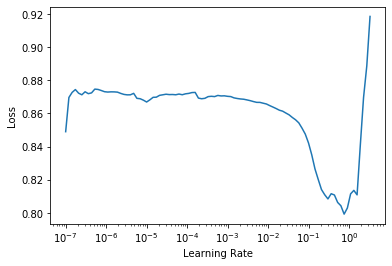

In [28]:
clslearn.lr_find(suggestions=True)

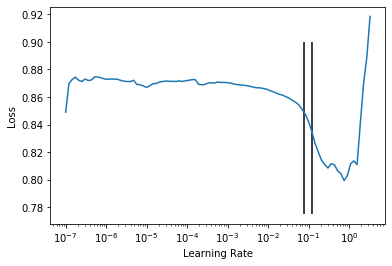

In [29]:
clslearn.recorder.plot_lr_find()
plt.vlines(0.07585893, 0.775, 0.9)
plt.vlines(0.1202, 0.775, 0.9)

In [30]:
clslearn.dls.bs

16

In [31]:
clslearn.freeze()
clslearn.dls.bs=8
clslearn.fit_flat_cos(10, 7e-2, pct_start=0.5)

epoch,train_loss,valid_loss,spearmanrho,time
0,0.539860,0.404946,0.211847,01:34
1,0.536552,0.403057,0.221698,01:40
2,0.534389,0.396808,0.225595,01:30
3,0.536893,0.403334,0.231928,01:26
4,0.535830,0.469535,0.234063,01:27
5,0.532458,0.397024,0.227637,01:32
6,0.529565,0.400015,0.228583,01:28
7,0.530989,0.396822,0.247264,01:28
8,0.523673,0.390516,0.244649,01:31
9,0.525921,0.390614,0.250179,01:42


In [32]:
clslearn.save('cls_large_quest_stg1_7e_7e-2_2020-02-09')

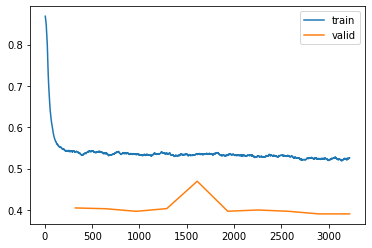

In [33]:
clslearn.recorder.plot_loss()

## Stage 2

(2.5118865210060903e-08, 3.311311274956097e-06)

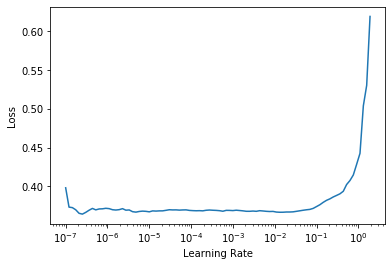

In [29]:
clslearn.load('cls_large_quest_stg1_7e_7e-2_2020-02-09')
clslearn.unfreeze()
clslearn.lr_find(suggestions=True)

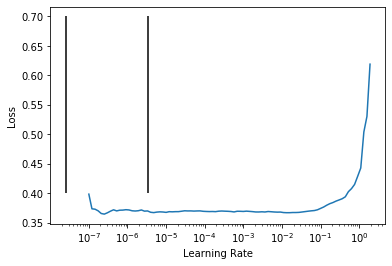

In [30]:
clslearn.recorder.plot_lr_find()
plt.vlines(2.511e-08, 0.4, 0.7)
plt.vlines(3.31e-06, 0.4, 0.7)

In [31]:
clslearn.unfreeze()
clslearn.fit_one_cycle(5, slice(5e-7, 1e-5), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,time
0,0.370523,0.376575,00:56
1,0.368486,0.376268,00:58
2,0.369277,0.376071,00:58
3,0.369982,0.375617,00:55
4,0.368503,0.375364,00:57


In [32]:
clslearn.save('cls_quest_stg3_5e_1e-5_2020-02-07')

## Get Predictions and Create Submission File

Create Test Dataloader. The code below adds the test set to both the train and valid dl. fastai2 actually has a way to create a test_dl, but I didn't have time to look into it.

In [ ]:
bs = 32
sl = 72
tst_splits = [list(range(len(tst_df))),list(range(len(tst_df)))]
x_tfms = [attrgetter('doc'), tok_fn, Numericalize(vocab=lm_vocab)]

tst_cls_dsets = Datasets(tst_df, splits=tst_splits, tfms=[x_tfms], dl_type=SortedDL)

tst_cls_dls = tst_cls_dsets.dataloaders(bs=bs, sl=sl, shuffle_train=False, device='cuda', 
                                    before_batch=pad_input_chunk, dl_type=SortedDL)
tst_cls_dls.show_batch(max_n=3)

In [ ]:
clslearn.dls = tst_cls_dls

### Make Predictions

In [ ]:
preds = clslearn.get_preds(dl=tst_cls_dls.valid)

### Sort Predictions
Sort our predictions back to the original input order, **very important** if making submissions to a kaggle competition

In [ ]:
pred_idxs = tst_cls_dls.get_idxs()
sorted_preds = [x for _,x in sorted(zip(pred_idxs, list(torch.unbind(preds[0]))))]

In [ ]:
sorted_preds_t = torch.stack(sorted_preds)
sorted_preds_t.size(), preds[0].size()

### Create submission file

In [ ]:
submission_df = pd.read_csv('/home/morgan/ml/data/google-quest-challenge/sample_submission.csv')
submission_df[label_cols] = sorted_preds_t 
submission_df.head()

In [ ]:
sub_file_name = 'submission.csv'
submission_df.to_csv(sub_file_name, index=False)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')